In [1]:
##############################################################
# import packages
##############################################################
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from skimage.io import imsave
from skimage import img_as_ubyte
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

In [2]:
##############################################################
# set output folders and output format
##############################################################
datasetInput1 = 'original/images/'
datasetInput2 = 'generated/images/'
# output format
var_image_out_size = (256,256,3)

# select running environment
# 0: local, 1: Colab, 2: AWS
env_mode = 0
if(env_mode == 0):
  working_path = os.getcwd()
  print(working_path)
elif(env_mode == 1):
  from google.colab import drive
  drive.mount('/content/drive/')
  working_path = '/content/drive/My Drive/RecolorizationEncDecIResNet'
# change working directory
if os.getcwd() != working_path:
  os.chdir(working_path)
current_path = os.getcwd()

##############################################################
# set paths to subfolders
##############################################################
input_path1 = current_path + '/postprocessing/datasets/' + datasetInput1
input_path2 = current_path + '/postprocessing/datasets/' + datasetInput2
output_path_images = current_path + '/postprocessing/datasets/output/'

C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet


In [3]:
##############################################################
# import, resize, add padding and save output
##############################################################
# number of images to import
print(input_path1)
filelist = os.listdir(input_path1)
num_input_images = len(filelist)
print('images to import: ', num_input_images)
# read data
image_resized = []
counter = 0
counter_correct_class = 0
counter_wo_white = 0
counter_wo_white_correct_1 = 0
counter_wo_white_correct_2 = 0
L2_loss = 0.0
histogram1 = np.zeros((32,32))
histogram2 = np.zeros((32,32))
num_pixels = var_image_out_size[0]*var_image_out_size[1]
for filename in os.listdir(input_path1):
    if(counter < num_input_images):
      image1 = Image.open(input_path1+filename)
      image2 = Image.open(input_path2+filename)

      # extract a,b channels
      counter +=1
      buffer = img_to_array(image1)
      buffer_lab1 = rgb2lab(buffer/255)
      buffer_a1 = np.reshape(buffer_lab1[:,:,1], (num_pixels,1))
      buffer_b1 = np.reshape(buffer_lab1[:,:,2], (num_pixels,1)) 
      buffer = img_to_array(image2)
      buffer_lab2 = rgb2lab(buffer/255)
      buffer_a2 = np.reshape(buffer_lab2[:,:,1], (num_pixels,1))
      buffer_b2 = np.reshape(buffer_lab2[:,:,2], (num_pixels,1))    
        
      # compute histogram 
      for i in range(num_pixels):
        L2_loss += ((buffer_a1[i] - buffer_a2[i])**2 + (buffer_b1[i] - buffer_b2[i])**2) / 2
                    
        id_x1 = int(32 * (buffer_a1[i] + 128) / 256 + 0.5)
        id_y1 = int(32 * (buffer_b1[i] + 128) / 256 + 0.5)

        id_x2 = int(32 * (buffer_a2[i] + 128) / 256 + 0.5)
        id_y2 = int(32 * (buffer_b2[i] + 128) / 256 + 0.5)
        
        if(id_x1 == id_x2 and id_y1 == id_y2):
           counter_correct_class += 1 
        if(id_x1 != 16 and id_y1 != 16):
            counter_wo_white += 1
            if(np.abs(id_x1 - id_x2)<=1 and np.abs(id_y1 - id_y2)<=1):
               counter_wo_white_correct_1 += 1 
            if(np.abs(id_x1 - id_x2)<=2 and np.abs(id_y1 - id_y2)<=2):
               counter_wo_white_correct_2 += 1 
        
        histogram1[id_x1, id_y1] += 1
        histogram2[id_x2, id_y2] += 1
          
      if(counter % 100 == 0):
        print('number of imported and analyzed images: ', counter)


C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/postprocessing/datasets/original/images/
images to import:  1


58 101
0.415740966796875
0.24135480814779725
0.48570977419864203
[212.31875528]
probability check:  1.0 1.0 0.0 0.65960693359375


<ipython-input-4-1fd12a1d968a>:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(prob_diff_abs), cmap='viridis', extent = [0 , 30, 30, 0], origin='upper')  #interpolation='nearest'


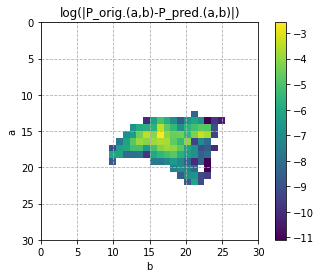

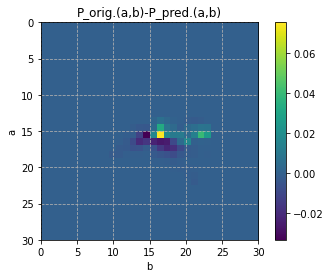

In [4]:
# count color classes
counter_orig_class = 0
counter_pred_class = 0
for i in range(32):
    for j in range(32):
        if(histogram1[i,j]>0):
            counter_orig_class+=1
        if(histogram2[i,j]>0):
            counter_pred_class+=1
print(counter_orig_class, counter_pred_class)
print(counter_correct_class/(counter * num_pixels))
print(counter_wo_white_correct_1/counter_wo_white)
print(counter_wo_white_correct_2/counter_wo_white)
# averaged L2-loss
L2_loss /= (counter*num_pixels)
print(L2_loss)
prob_ab1 = histogram1 / (counter * num_pixels)
prob_ab2 = histogram2 / (counter * num_pixels)
prob_diff = prob_ab1 - prob_ab2
prob_diff_abs = np.abs(prob_ab1 - prob_ab2)
print('probability check: ', np.sum(prob_ab1), np.sum(prob_ab2), np.sum(prob_diff), np.sum(prob_diff_abs))
list_ab = []
for i in range(32):
    for j in range(32):
        if(prob_diff[i,j] > 0.0):
            list_ab.append((i/32 * 256 - 128,j/32 * 256 - 128, prob_diff[i,j], prob_diff_abs[i,j]))       

plt.imshow(np.log(prob_diff_abs), cmap='viridis', extent = [0 , 30, 30, 0], origin='upper')  #interpolation='nearest'
plt.xlabel('b')
plt.ylabel('a')
plt.title('log(|P_orig.(a,b)-P_pred.(a,b)|)')
plt.colorbar()
plt.grid(linestyle='--')
#plt.imsave(fname=output_path_prob, arr=np.log(prob_ab), cmap='viridis', origin='upper', format='png')
plt.show()

plt.imshow(prob_diff, cmap='viridis', extent = [0 , 30, 30, 0], origin='upper')  #interpolation='nearest'
plt.xlabel('b')
plt.ylabel('a')
plt.title('P_orig.(a,b)-P_pred.(a,b)')
plt.colorbar()
plt.grid(linestyle='--')
#plt.imsave(fname=output_path_prob, arr=np.log(prob_ab), cmap='viridis', origin='upper', format='png')
plt.show()